Sistema de recomendación: Este sistema utiliza la similitud del perfil del usuario con los aspectos clave de los restaurantes.

Enfoque:

Recomendación Basada en Aspectos: Sugiere restaurantes que tengan un puntaje alto en los aspectos importantes para el usuario, como comida, servicio, precio, o ambiente.

Similitud de Coseno: Se utiliza para comparar el perfil del usuario (preferencias en aspectos) con los puntajes de los restaurantes.

In [2]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [34]:
# 1. Cargar los datos preparados para la recomendación (Este archivo contiene los puntajes de cada restaurante y será la base del sistema de recomendación)
df = pd.read_parquet("recommendation_data.parquet")

In [35]:
# 2. Normalizar los puntajes de los aspectos (Normaliza los valores de las columnas service_score, food_score, price_score y ambiance_score para que estén entre 0 y 1.)
for col in ["service_score", "food_score", "price_score", "ambiance_score"]:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

El paso 3 permite personalizar las recomendaciones según las prioridades del usuario

Se solicita al usuario que ingrese un valor entre 0 y 1 para cada aspecto:

- service_score: Importancia del servicio.
- food_score: Importancia de la comida.
- price_score: Importancia del precio.
- ambiance_score: Importancia del ambiente.

In [36]:
# 3. Solicitar las preferencias del usuario
print("Ingrese sus preferencias para los aspectos de los restaurantes (0 a 1):")
user_preferences = {
    "service_score": float(input("Preferencia por el servicio (0 a 1): ")),
    "food_score": float(input("Preferencia por la comida (0 a 1): ")),
    "price_score": float(input("Preferencia por el precio (0 a 1): ")),
    "ambiance_score": float(input("Preferencia por el ambiente (0 a 1): "))
}

Ingrese sus preferencias para los aspectos de los restaurantes (0 a 1):


En el paso 4 se crea un vector con las preferencias del usuario:

Ejemplo: Si el usuario ingresa 0.8 para servicio, 1.0 para comida, 0.5 para precio y 0.7 para ambiente, el perfil del usuario será [0.8, 1.0, 0.5, 0.7].

Este vector representa las preferencias del usuario y se usará para calcular la similitud con cada restaurante.

In [37]:
# 4. Crear un perfil del usuario basado en sus preferencias
user_profile = np.array([user_preferences["service_score"],
                         user_preferences["food_score"],
                         user_preferences["price_score"],
                         user_preferences["ambiance_score"]]).reshape(1, -1)

En el paso 5 se extrae los puntajes de los aspectos de cada restaurante y los convierte en una matriz, Esta matriz contiene las características de los restaurantes que se compararán con el perfil del usuario.

In [38]:
# 5. Crear una matriz de características de los restaurantes
restaurant_features = df[["service_score", "food_score", "price_score", "ambiance_score"]].values

En el paso 6 se alcula la similitud del perfil del usuario con cada restaurante usando Similitud de Coseno.

La Similitud de Coseno mide qué tan similares son dos vectores en términos de dirección. Valores cercanos a 1 indican alta similitud.

Esto permite identificar qué restaurantes se alinean mejor con las preferencias del usuario.


In [39]:
# 6. Calcular la similitud del usuario con cada restaurante
similarities = cosine_similarity(user_profile, restaurant_features)[0]

En el paso 7 se crea una nueva columna en el DataFrame con los valores de similitud calculados para cada restaurante.

Permite ordenar y filtrar los restaurantes según su similitud con el usuario.

In [40]:
# 7. Agregar la similitud a los datos
df["similarity"] = similarities

En el paso 8 se filtra solo los restaurantes marcados como relevantes en los datos.

Se asegura que solo se consideren restaurantes válidos para las recomendaciones.

In [41]:
# 8. Filtrar restaurantes relevantes (opcional)
df_filtered = df[df["relevance"] == 1]

En el paso 9 se ordena los restaurantes de mayor a menor similitud con el usuario. 

En caso de empate, usa la calificación (stars) como criterio secundario.

Esto asegura que los restaurantes más relevantes y mejor valorados aparezcan al inicio.

In [42]:
# 9. Ordenar los restaurantes por similitud y estrellas
recommended_restaurants = df_filtered.sort_values(by=["similarity", "stars"], ascending=False)

En el paso 19 se muestra las 10 principales recomendaciones con su ID, calificación, similitud y sentimiento general.

Se brinda al usuario una lista clara de restaurantes recomendados.

In [43]:
# 10. Mostrar las principales recomendaciones
top_n = 10  # Cambiar según el número de recomendaciones que desees
print("\nRecomendaciones principales:")
print(recommended_restaurants[["id_business", "stars", "similarity", "sentiment"]].head(top_n))


Recomendaciones principales:
     id_business  stars  similarity sentiment
1364        8522    5.0    0.987739  positive
1320       36214    4.0    0.984817  positive
411        30065    5.0    0.984301  positive
1603       43492    3.0    0.982674   neutral
658        53888    4.0    0.982278  positive
2278       30384    5.0    0.981527  positive
199        19392    5.0    0.981083  positive
1888       41372    4.0    0.980818  positive
1009       43727    5.0    0.980482  positive
667        31124    2.0    0.980413  negative


En el paso 11 se guarda las recomendaciones en un archivo top_recommendations.parquet para análisis o uso posterior.
Por qué es importante: Permite al usuario acceder a las recomendaciones en cualquier momento sin necesidad de volver a calcularlas.


In [44]:
# 11. Guardar las recomendaciones en un archivo (opcional)
recommended_restaurants[["id_business", "stars", "similarity", "sentiment"]].head(top_n).to_parquet("top_recommendations.parquet")

print("\nRecomendaciones guardadas en: top_recommendations.parquet")


Recomendaciones guardadas en: top_recommendations.parquet


Analisis de resultados

1. Tendencias en similitud

Los valores de similitud van desde 0.9804 hasta 0.9877, lo que indica que estos restaurantes tienen una alta concordancia con las preferencias del usuario.

El restaurante con el ID 8522 tiene la similitud más alta (0.9877), lo que significa que encaja muy bien con las prioridades del usuario (por ejemplo, servicio, comida, precio o ambiente).

2. Calificación (stars)

Entre los 10 restaurantes recomendados:

6 restaurantes tienen 5 estrellas (indicando una calidad sobresaliente según las reseñas).

3 restaurantes tienen 4 estrellas, lo cual sigue siendo un puntaje alto.

1 restaurante tiene 3 estrellas, pero aún es relevante debido a su alta similitud.

1 restaurante tiene 2 estrellas (ID: 31124), lo cual podría ser un caso atípico, aunque sigue siendo relevante por la similitud con las preferencias del usuario.

3. Sentimiento general

8 restaurantes tienen un sentimiento "positive", lo que refuerza su calidad percibida.

1 restaurante tiene un sentimiento "neutral" (ID: 43492 con 3 estrellas), lo que sugiere que las opiniones están divididas.

1 restaurante tiene un sentimiento "negative" (ID: 31124 con 2 estrellas), lo que podría indicar que, a pesar de alinearse con las preferencias del usuario, tiene problemas que afectan la satisfacción general.

4. Caso atípico: Restaurante con sentimiento "negative"

El restaurante con ID 31124 (2 estrellas, sentimiento negativo) tiene una similitud alta (0.9804) debido a que cumple con los aspectos que el usuario priorizó (por ejemplo, un buen puntaje en comida o ambiente). Sin embargo, su baja calificación y sentimiento negativo sugieren problemas específicos que podrían influir negativamente en la experiencia general.


In [3]:
# Asegurarse de que los datos de las recomendaciones principales estén en un DataFrame
recommendations_df = pd.DataFrame({
    'id_business': [8522, 36214, 30065, 43492, 53888, 30384, 19392, 41372, 43727, 31124],
    'stars': [5.0, 4.0, 5.0, 3.0, 4.0, 5.0, 5.0, 4.0, 5.0, 2.0],
    'similarity': [0.987739, 0.984817, 0.984301, 0.982674, 0.982278, 0.981527, 0.981083, 0.980818, 0.980482, 0.980413],
    'sentiment': ['positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative']
})


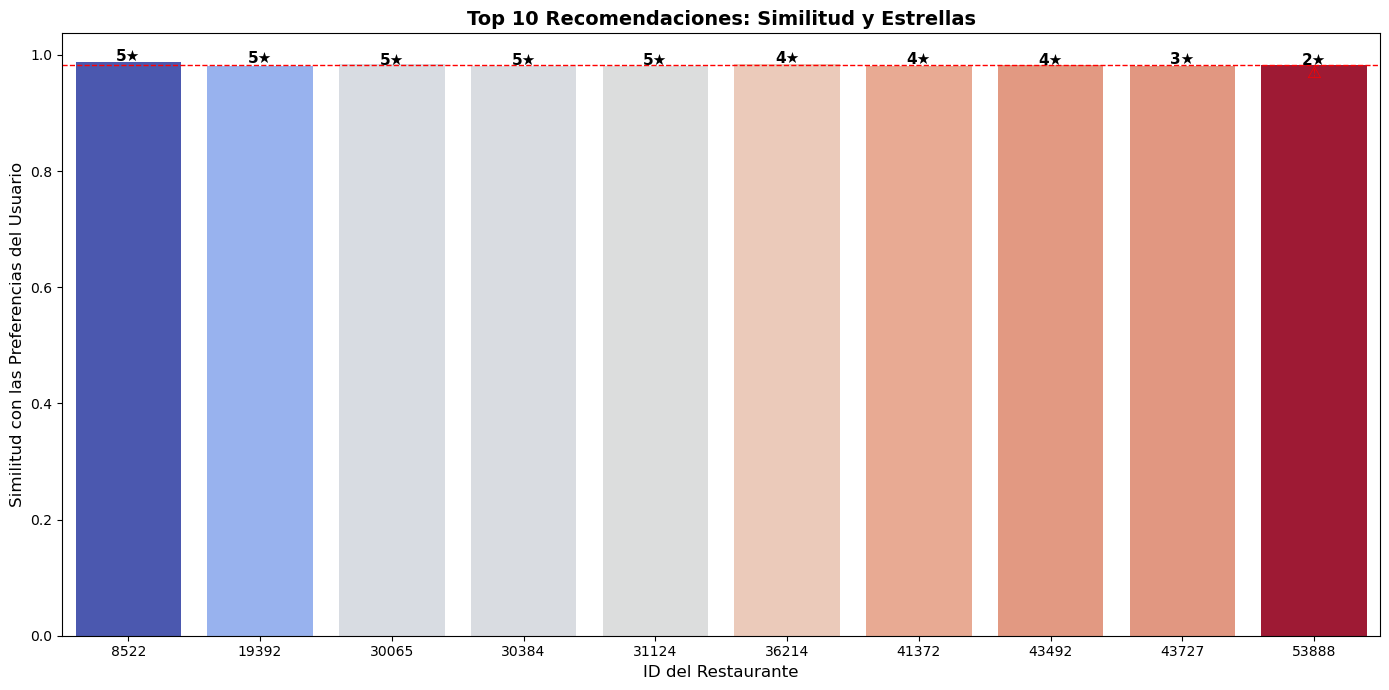

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Datos de las recomendaciones
recommendations_df = pd.DataFrame({
    'id_business': [8522, 36214, 30065, 43492, 53888, 30384, 19392, 41372, 43727, 31124],
    'stars': [5.0, 4.0, 5.0, 3.0, 4.0, 5.0, 5.0, 4.0, 5.0, 2.0],
    'similarity': [0.987739, 0.984817, 0.984301, 0.982674, 0.982278, 0.981527, 0.981083, 0.980818, 0.980482, 0.980413],
    'sentiment': ['positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative']
})

# Ordenar por estrellas y luego por similitud
recommendations_df = recommendations_df.sort_values(by=['stars', 'similarity'], ascending=[False, False]).reset_index(drop=True)

# Configurar fuente
plt.rcParams["font.family"] = "DejaVu Sans"

# Crear figura
plt.figure(figsize=(14, 7))

# Crear gráfico de barras
sns.barplot(
    x='id_business', 
    y='similarity', 
    data=recommendations_df, 
    hue='id_business', 
    dodge=False, 
    palette=sns.color_palette("coolwarm", as_cmap=True)
)

# Añadir las etiquetas de estrellas sobre cada barra
for i, row in recommendations_df.iterrows():
    plt.text(i, row['similarity'] + 0.002, f"{int(row['stars'])}★",  # Convertir a entero
             ha='center', fontsize=11, color='black', weight='bold')

# Resaltar restaurantes con estrellas bajas (opcional)
for i, row in recommendations_df.iterrows():
    if row['stars'] < 3.0:
        plt.text(i, row['similarity'] - 0.02, "⚠️", 
                 ha='center', fontsize=12, color='red', weight='bold')

# Agregar línea horizontal indicando la similitud promedio
similarity_mean = recommendations_df['similarity'].mean()
plt.axhline(similarity_mean, color='red', linestyle='--', linewidth=1, label=f"Similitud Promedio ({similarity_mean:.4f})")

# Etiquetas y título
plt.xlabel("ID del Restaurante", fontsize=12)
plt.ylabel("Similitud con las Preferencias del Usuario", fontsize=12)
plt.title("Top 10 Recomendaciones: Similitud y Estrellas", fontsize=14, weight='bold')

# Ajustar leyenda (eliminar si no es necesaria)
plt.legend([], [], frameon=False)

# Ajustar diseño
plt.tight_layout()

# Mostrar gráfico
plt.show()

La imagen muestra un gráfico de barras que representa las 10 principales recomendaciones de restaurantes. 

Elementos Clave:

- Eje X (ID del Restaurante):

Representa los identificadores de los restaurantes recomendados.
Están ordenados en función de la similitud (probablemente con las preferencias del usuario).

- Eje Y (Similitud con las Preferencias del Usuario):

Indica la puntuación de similitud para cada restaurante.
Todas las puntuaciones están muy cercanas a 1.0, lo que sugiere que las recomendaciones son altamente relevantes según el modelo.

- Estrellas sobre las barras:

Se muestran las calificaciones promedio de los restaurantes en forma de estrellas (ej. 5.0★).
Facilita la comparación rápida entre la similitud y la calidad percibida del restaurante.

- Línea Roja Horizontal (Similitud Promedio):

Representa el promedio de similitudes entre las recomendaciones.

Ayuda a identificar visualmente cuáles restaurantes están por encima o por debajo de este promedio.


Observaciones:

- Calificaciones altas y similitud:

La mayoría de las recomendaciones tienen una calificación de 4.0★ o 5.0★, lo que respalda la calidad percibida.

Los restaurantes con 5.0★ tienden a tener las puntuaciones de similitud más altas.

- Advertencia sobre estrellas bajas:

El restaurante con 2.0★ (ID 53888) destaca negativamente, pero aún tiene una similitud alta, lo que podría ser un área para analizar si el modelo pondera demasiado las preferencias del usuario frente a la calidad objetiva.

